## lenstronomy lens equation solver and flux ratios computation example notebook

In [1]:
import copy
import numpy as np

# import the lens model class 
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# import lens model solver with 4 image positions constrains
from lenstronomy.LensModel.Solver.solver4point import Solver4Point

In [2]:
# chose a lens model (list of parameterized lens models)
lens_model_list = ['SPEMD', 'SHEAR', 'NFW', 'NFW']

#initialize classes with the specific lens models
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)
solver4Point = Solver4Point(lensModel=lensModel, decoupling=True, solver_type='PROFILE_SHEAR')

In [3]:
# chose a lens model parameterization
kwargs_spep = {'theta_E': 1., 'gamma': 2, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.01, 'center_y': 0}
kwargs_shear = {'e1': 0.03, 'e2': -0.02}
kwargs_nfw_1 = {'theta_Rs': 0.1, 'Rs': 0.1, 'center_x': 1.5, 'center_y': 0}
kwargs_nfw_2 = {'theta_Rs': 0.1, 'Rs': 0.1, 'center_x': 0, 'center_y': 0.5}
kwargs_lens_list = [kwargs_spep, kwargs_shear, kwargs_nfw_1, kwargs_nfw_2]

# choose a source position
x_source, y_source = 0.05, 0

In [4]:
# compute image position of full model (with numerical options attached)
x_image, y_image = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, sourcePos_x=x_source, sourcePos_y=y_source, min_distance=0.01, search_window=5, precision_limit=10**(-10), num_iter_max=100)
print('image positions: ', x_image)
# check solver precision by ray-tracing the image positions back into the source plane
x_source_new, y_source_new = lensModel.ray_shooting(x_image, y_image, kwargs_lens_list)
print("the relative precision of the image positions are: ", x_source_new - x_source)

('image positions: ', array([ 0.75746749, -0.88216636, -0.86994398,  0.61329272]))
('the relative precision of the image positions are: ', array([ 4.73503181e-12,  3.08712778e-12, -3.10264731e-11, -3.72542275e-12]))


In [5]:
# fit the same lens model parameterization to the 4 image positions (free SPEMD model)
# the initial guess of the model can be rather different but 'gamma' has to be kept fixed
kwargs_lens_init = copy.deepcopy(kwargs_lens_list)
kwargs_lens_init[0] = {'theta_E': 0.9, 'gamma': 2., 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}

kwargs_fit, precision = solver4Point.constraint_lensmodel(x_pos=x_image, y_pos=y_image, kwargs_list=kwargs_lens_init, xtol=1.49012e-10)
print('the relative error of the Einstein radius is: ', kwargs_fit[0]['theta_E'] - kwargs_lens_list[0]['theta_E'])

('the relative error of the Einstein radius is: ', 2.4065816006668683e-10)


In [6]:
# now we fit the point sources with a simpler model (only SPEMD and SHEAR without the NFWs)
lens_model_list_simple = ['SPEMD', 'SHEAR']
lensModelSimple = LensModel(lens_model_list_simple)
solver4Point_simple = Solver4Point(lensModel=lensModelSimple, decoupling=True, solver_type='PROFILE_SHEAR')
kwargs_lens_init = [{'theta_E': 0.9, 'gamma': 2., 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}, {'e1': 0.05, 'e2': -0.0}]

kwargs_fit_simple, precision = solver4Point_simple.constraint_lensmodel(x_pos=x_image, y_pos=y_image, kwargs_list=kwargs_lens_init, xtol=1.49012e-10)
print("the re-fitted macro-model parameters are: ", kwargs_fit_simple)

# check whether this simpler solution obeys the lens equation
lensModel_simple = LensModel(lens_model_list_simple)
beta_x_new, beta_y_new = lensModel_simple.ray_shooting(x_image, y_image, kwargs_fit_simple)
print("The relative position in the source plane (should match) is: ", beta_x_new - np.mean(beta_x_new))

# we can now set a new estimate of the source position
beta_x_new = np.mean(beta_x_new)
beta_y_new = np.mean(beta_y_new)
# and solve for the new image positions (which should come very close to the true ones)
lensEquationSolver_new = LensEquationSolver(lensModel=lensModel_simple)
x_image_new, y_image_new = lensEquationSolver_new.image_position_from_source(kwargs_lens=kwargs_fit_simple, sourcePos_x=beta_x_new, sourcePos_y=beta_y_new, min_distance=0.01, search_window=5, precision_limit=10**(-10), num_iter_max=100)

print x_image - x_image_new

('the re-fitted macro-model parameters are: ', [{'theta_E': 1.0682034353739778, 'center_x': 0.04356960376898146, 'center_y': 0.028123970695691957, 'e1': 0.07756241953556046, 'gamma': 2.0, 'e2': 0.0384318348934315}, {'e1': 0.04307239811687295, 'e2': -0.025392292540485584}])
('The relative position in the source plane (should match) is: ', array([ 1.55375712e-13, -2.05391260e-15, -4.32154312e-13,  2.78832513e-13]))
[-2.51432208e-12 -6.32494057e-13  6.64790445e-12  2.29793962e-12]


In [32]:
# now let's compute the magnification at the point source position (infinitesly small source)
mag = lensModel.magnification(x_image, y_image, kwargs_lens_list)
mag_macro = lensModel_simple.magnification(x_image, y_image, kwargs_fit_simple)
print mag, mag_macro

scaling = 1
# and the magnification of a finite source size
source_sigma = 0.001*scaling  # source size in arcsec
import lenstronomy.Util.constants as const
arcsec2pc = const.arcsec * 1000 * 10**6
print source_sigma*arcsec2pc
window_size = 0.5*scaling  # size of window to compute fluxes on every image
grid_number = 500  # number of grid points per axis in the window
lensModelExtensions = LensModelExtensions(lens_model_list=lens_model_list)
fluxes = lensModelExtensions.magnification_finite(x_image, y_image, kwargs_lens=kwargs_lens_list, grid_number=grid_number, source_sigma=source_sigma, window_size=window_size, shape='GAUSSIAN')
print fluxes

lensModelExtensions_simple = LensModelExtensions(lens_model_list=lens_model_list_simple)
fluxes_simple = lensModelExtensions_simple.magnification_finite(x_image, y_image, kwargs_lens=kwargs_fit_simple, grid_number=grid_number, source_sigma=source_sigma, window_size=window_size, shape='GAUSSIAN')
print fluxes_simple

[-19.92171399 -10.0359916   11.57386933   6.98030204] [ -7.60345102 -12.20643965  12.08863629   9.44826889]
4.8481368111
[19.92070209 10.03751787 11.57695711  6.98071545]
[ 7.60332614 12.21163787 12.09795569  9.4483836 ]


## some plots

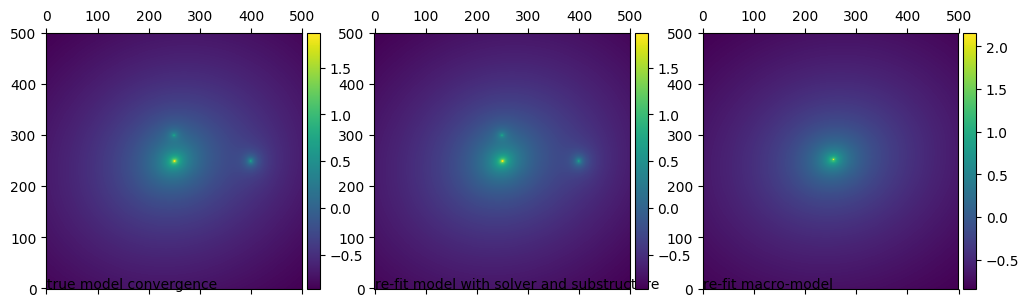

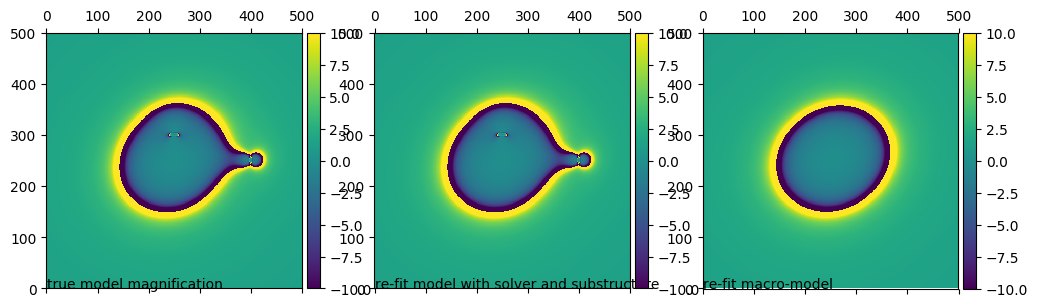

In [8]:
# make a pixel grid suited for plotting
import astrofunc.util as util

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

x_grid, y_grid = util.make_grid(numPix=500, deltapix=0.01)

# plot convergence
kappa_grid = lensModel.kappa(x_grid, y_grid, kwargs_lens_list)
kappa2d = util.array2image(kappa_grid)

kappa_grid = lensModel.kappa(x_grid, y_grid, kwargs_fit)
kappa2d_fit = util.array2image(kappa_grid)

kappa_grid = lensModel_simple.kappa(x_grid, y_grid, kwargs_fit_simple)
kappa2d_simple = util.array2image(kappa_grid)




f, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)

ax = axes[0]
im = ax.matshow(np.log10(kappa2d), origin='lower')
ax.text(1, 1, 'true model convergence')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
im = ax.matshow(np.log10(kappa2d_fit), origin='lower')
ax.text(1, 1, 're-fit model with solver and substructure')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[2]
im = ax.matshow(np.log10(kappa2d_simple), origin='lower')
ax.text(1, 1, 're-fit macro-model')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()




# plot magnification
mag_grid = lensModel.magnification(x_grid, y_grid, kwargs_lens_list)
mag2d = util.array2image(mag_grid)

mag_grid = lensModel.magnification(x_grid, y_grid, kwargs_fit)
mag2d_fit = util.array2image(mag_grid)

mag_grid = lensModel_simple.magnification(x_grid, y_grid, kwargs_fit_simple)
mag2d_simple = util.array2image(mag_grid)


import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

f, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)

ax = axes[0]
im = ax.matshow(mag2d, origin='lower', vmin=-10, vmax=10)
ax.text(1, 1, 'true model magnification')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
im = ax.matshow(mag2d_fit, origin='lower', vmin=-10, vmax=10)
ax.text(1, 1, 're-fit model with solver and substructure')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[2]
im = ax.matshow(mag2d_simple, origin='lower', vmin=-10, vmax=10)
ax.text(1, 1, 're-fit macro-model')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()


